# TXPipe - CLMM Data Preparation

This notebook runs and explores two pipelines that generate the weighted, calibrated, per-cluster background shear catalogs as inputs to CLMM.

Before starting you will need to:
- set up the TXPipe environment at CC-IN2p3 using the command 
`source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe`
- clone the TXPipe repository somewhere, preferably in the SPS space since we will make some large files.
- downloaded the two input catalogs: [1 square degree](https://portal.nersc.gov/cfs/lsst/txpipe/data/example.tar.gz) and [20 square degrees](https://portal.nersc.gov/cfs/lsst/txpipe/data/cosmodc2-20deg2.tar.gz) and unzipped them in your TXPipe clone directory.

In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci

# 1 deg$^2$ Sample

First we will do some runs on the 1 deg^2 example data set with around 80k galaxies. This is small enough that we can do it all in jupyter.

The data set, which is based on CosmoDC2, contains pre-computed photo-z and and contains a RedMapper cluster catalog for the field.

We will clone our own copy of the TXPipe directory, and run this notebook from there.  Please update this variable to your own version of the path when running this:

In [2]:
#my_txpipe_dir = "/sps/lsst/users/jzuntz/TXPipe"
my_txpipe_dir = "/pbs/throng/lsst/users/ccombet/TXPipe"
os.chdir(my_txpipe_dir)

import txpipe

Now we make an output directory for everything, if it doesn't exist already.

In [3]:
os.makedirs("data/example/outputs_metadetect", exist_ok=True)

In [4]:
if not os.path.exists("data/example/inputs/metadetect_shear_catalog.hdf5"):
    raise RuntimeError("Download and extract the sample data file to continue")

---

## WL sample selection

Our first step is the WL sample selection. This does both selection and tomography. The latter is not used here.

In [5]:
step1 = txpipe.TXSourceSelectorMetadetect.make_stage(
    # This file is the input metadetect shear catalog
    shear_catalog="data/example/inputs/metadetect_shear_catalog.hdf5",
    # This is an input training set for the tomographic selection
    calibration_table="data/example/inputs/sample_cosmodc2_w10year_errors.dat",

    # This contains all the options for this stage. You can override them here
    # manually too.
    config="examples/metadetect/config.yml",

    # This is the output file for this stage
    shear_tomography_catalog="data/example/outputs_metadetect/shear_tomography_catalog.hdf5"
)

This step will first train a classifier to select objects into tomographic bins, and then run it on the input data files
to produce the output file:

In [6]:
step1.run()
step1.finalize()

Using these bands to train the tomography selector: riz
Training data for bin classifier has shape  (104104, 6)
Using these bin edges: [0.5, 0.7, 0.9, 1.1, 2.0]
Training set: 15418 objects in tomographic bin 0
Training set: 21016 objects in tomographic bin 1
Training set: 17401 objects in tomographic bin 2
Training set: 27951 objects in tomographic bin 3
Process 0 running selection for rows 0-82,200


---

## Cluster shear catalog indexing and weights

Our second step runs the matching to find the shear catalog behind every cluster.

This step saves a cluster shear catalog, which is actually just an index into the shear and cluster catalogs (to avoid making many copies of the data), with added weights from CLMM

In [7]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterShearCatalogs.config_options)

step2 = txpipe.extensions.CLClusterShearCatalogs.make_stage(
    # Shear catalog, as before
    shear_catalog="data/example/inputs/metadetect_shear_catalog.hdf5",
    # This is the initial cluster catalog - RAs, Decs, richess, redshift, etc.
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    # This fiducial cosmology is used to convert distance separations to redshifts
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    # The tomography catalog created in step 1 selects objects for the WL sample
    # and assigns them to tomographic bins. We don't need the tomography here, just the basic selection
    shear_tomography_catalog="data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    # This is a QP file created by RAIL to generate the photo-zs for this sample
    source_photoz_pdfs="data/example/inputs/photoz_pdfs.hdf5",

    # This is the output for this stage
    cluster_shear_catalogs="my_cluster_shear_catalog.hdf5",

    # This contains all the options for this stage. You can override them here, as we do with the max_radius below.
    config="examples/metadetect/config.yml",    
    # Let's override one of the configuration parameters for this stage:
    max_radius=5.0
)


Options for this pipeline and their defaults:
{'chunk_rows': 100000, 'max_radius': 10.0, 'delta_z': 0.1, 'redshift_criterion': 'mean', 'subtract_mean_shear': True}


In [8]:
step2.run()
step2.finalize()

Min search angle =  10.055618853834702 arcmin
Mean search angle =  12.982302811813245 arcmin
Max search angle =  22.546543656168343 arcmin
Max theta_max = 0.0065585236957462975 radians = 22.546543656168343 arcmin
Using single 2D shear calibration!
Process 0 processing chunk 0 - 82,200
Process 0 done reading
Overall pair count =  73891
Found 1032 total galaxies in catalog for cluster 11
Found 995 total galaxies in catalog for cluster 827
Found 947 total galaxies in catalog for cluster 1985
Found 908 total galaxies in catalog for cluster 1632
Found 298 total galaxies in catalog for cluster 2453
Found 1080 total galaxies in catalog for cluster 2678
Found 556 total galaxies in catalog for cluster 4643
Found 234 total galaxies in catalog for cluster 5084
Found 854 total galaxies in catalog for cluster 4434
Found 703 total galaxies in catalog for cluster 3939
Found 1558 total galaxies in catalog for cluster 6139
Found 610 total galaxies in catalog for cluster 4709
Found 1612 total galaxies i

In [9]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterEnsembleProfiles.config_options)

step3 = txpipe.extensions.CLClusterEnsembleProfiles.make_stage(
    # Shear catalog, as before
    shear_catalog="data/example/inputs/metadetect_shear_catalog.hdf5",
    # This is the initial cluster catalog - RAs, Decs, richess, redshift, etc.
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    # This fiducial cosmology is used to convert distance separations to redshifts
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    # The tomography catalog created in step 1 selects objects for the WL sample
    # and assigns them to tomographic bins. We don't need the tomography here, just the basic selection
    shear_tomography_catalog="data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    # This is a QP file created by RAIL to generate the photo-zs for this sample
    source_photoz_pdfs="data/example/inputs/photoz_pdfs.hdf5",

    # This is the output for this stage
    cluster_shear_catalogs="my_cluster_ensemble_object.pkl",

    # This contains all the options for this stage. You can override them here, as we do with the max_radius below.
    config="examples/metadetect/config.yml",    
    # Let's override one of the configuration parameters for this stage:
    max_radius=5.0
)


Options for this pipeline and their defaults:
{'chunk_rows': 100000, 'max_radius': 10.0, 'delta_z': 0.1, 'redshift_criterion': 'mean', 'subtract_mean_shear': True}


In [10]:
step3.run()
step3.finalize()

NOTE/WARNING: Expected output file cluster_ensemble.pkl was not generated.


## Exploring the index

To avoid making lots and lots of copies of the data, this stage has not made a catalog, but instead made an index into the other catalogs, and stored only the relevant weight.

We have a helper class which is designed to match up all the different catalogs that go into this and collect the results for each cluster.

In [5]:
ccc = txpipe.extensions.CombinedClusterCatalog(
    shear_catalog="data/example/inputs/metadetect_shear_catalog.hdf5",
    shear_tomography_catalog="data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    cluster_shear_catalogs="my_cluster_shear_catalog.hdf5",
    photoz_pdfs="data/example/inputs/photoz_pdfs.hdf5",
)

In [12]:
print(f"Have {ccc.ncluster} clusters")

Have 75 clusters


We can extract the cluster catalog info by index (0 -- 74):

In [13]:
cluster_info = ccc.get_cluster_info(30)
cluster_info

{'cluster_id': 13025,
 'dec': -30.836898444380743,
 'ra': 60.05020139288286,
 'redshift': 0.549555,
 'redshift_err': 0.00606624,
 'richness': 12.757372,
 'richness_err': 1.6309212,
 'scaleval': 0.99993795}

A also the shear catalog associated with that cluster, again by index, in the CLMM data format:

In [14]:
bg_cat = ccc.get_background_shear_catalog(30)
bg_cat[0:3]

ra,dec,weight,e1,e2,distance_arcmin,zmean
float64,float64,float64,float64,float64,float64,float64
60.11656742699151,-30.8165211535348,1.0,-0.19247417638523737,0.8140476439562748,3.6314050727777794,1.5181753153396023
60.13755330706914,-30.755917515857256,1.0,-0.12467426935732773,0.4333612879130423,6.6239834332453205,1.9230154101078178
60.125519470746674,-30.70530274139535,1.0,0.5979982484225607,0.12837295413464536,8.798834059756327,1.9190015511987117


Since our field is so small here (1 deg^2) the background catalog may be cut off at the edges:

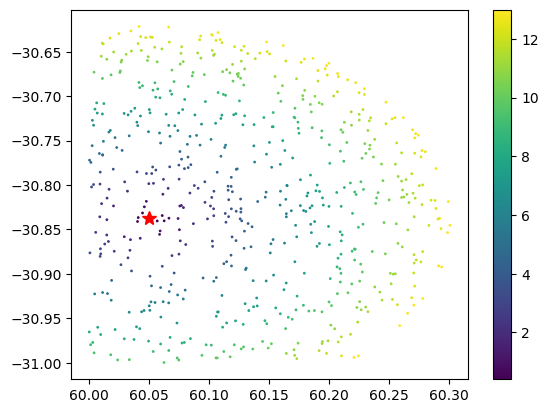

In [15]:
plt.scatter(bg_cat['ra'], bg_cat['dec'], c=bg_cat['distance_arcmin'], s=1)
plt.plot(cluster_info['ra'], cluster_info['dec'], 'r*', markersize=10)
plt.colorbar()

We can also look at the redshift-weight calculation result for this b/g sample to check it makes sense:

Text(0, 0.5, 'CLMM weight')

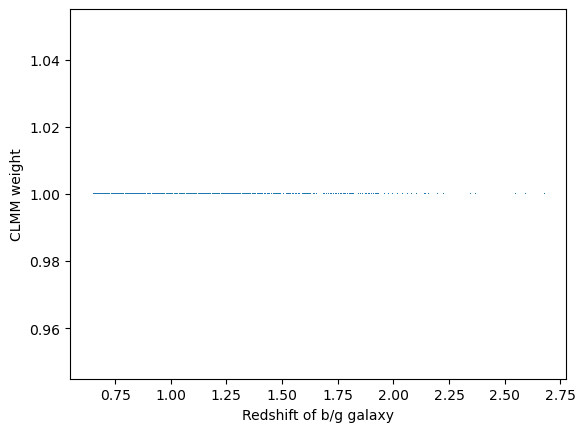

In [16]:
# plt.plot(bg_cat['zmean'], bg_cat['weight_clmm'], ',')
plt.plot(bg_cat['zmean'], bg_cat['weight'], ',')
plt.xlabel("Redshift of b/g galaxy")
plt.ylabel("CLMM weight")

# 20 deg$^2$ Sample

Our second input catalog contains a larger data set - 20 square degrees of CosmoDC2 data + mock noise, and an accompanying redmapper cluster catalog and mock spectroscopic sample.

It contains about 25 million galaxies and 1900 clusters.

This is large enough that it's worth running in parallel, instead of in Jupyter, especially because we have to calculate the photo-z for this sample, which is pretty slow.

In [12]:
if not os.path.exists("data/cosmodc2/20deg2/cluster_catalog.hdf5"):
    raise RuntimeError("Download and extract the 20 deg^2 data file to continue")

## Launching a pipeline at CC-IN2P3

Let's have a look at the submission script for this pipeline: `examples/cosmodc2/20deg2-in2p3.sub`:

In [16]:
! cat examples/cosmodc2/20deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=30
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe
ceci examples/cosmodc2/pipeline-20deg2-clmm.yml


This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline.

In a terminal, **navigate to your TXPipe directory and run**:

```
sbatch examples/cosmodc2/20deg2-in2p3.sub
```
to set it running.

## Investigating our pipeline

While that's running, let's have a look at what's in the pipeline.

First, we can use ceci to build a flow-chart showing the pipeline stages:

In [3]:
# Read the pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/pipeline-20deg2-clmm.yml"
flowchart_file = "20deg2.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

Now we can have a look at the chart it has created:

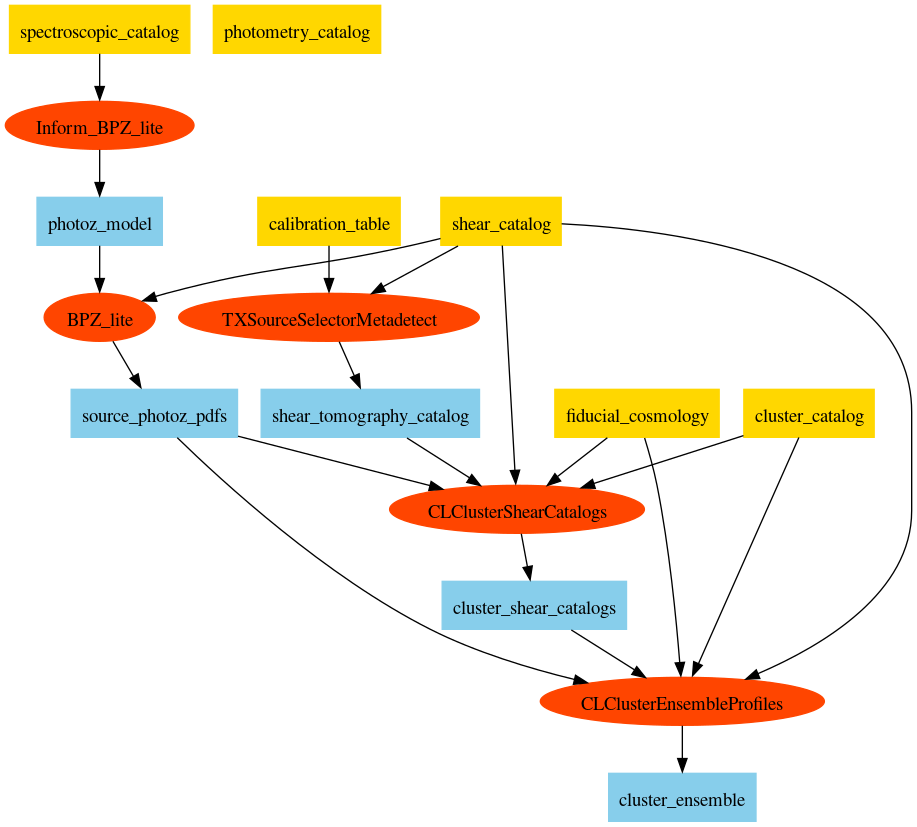

In [4]:
Image(flowchart_file)

Red ellipses are pipeline stages, each of which is a python class.

Yellow boxes are pre-existing input data files.

Blue boxes are files created by the pipeline.

We can sat that it generally makes sense - the final output is a set of cluster shear index catalogs, just like before.

Let's have a look at the pipeline information for this stage:


In [19]:
pprint(pipeline_config)

{'config': 'examples/cosmodc2/config-20deg2-clmm.yml',
 'dry_run': True,
 'flow_chart': '20deg2.png',
 'inputs': {'calibration_table': './data/cosmodc2/20deg2/sample_cosmodc2_w10year_errors.dat',
            'cluster_catalog': './data/cosmodc2/20deg2/cluster_catalog.hdf5',
            'fiducial_cosmology': 'data/fiducial_cosmology.yml',
            'photometry_catalog': './data/cosmodc2/20deg2/photometry_catalog.hdf5',
            'shear_catalog': './data/cosmodc2/20deg2/shear_catalog.hdf5',
            'spectroscopic_catalog': './data/cosmodc2/20deg2/spectroscopic_catalog.hdf5'},
 'launcher': {'dry_run': True,
              'flow_chart': '20deg2.png',
              'interval': 3.0,
              'name': 'mini'},
 'log_dir': 'data/cosmodc2/logs',
 'modules': 'txpipe rail.estimation.algos.bpz_lite\n',
 'output_dir': 'data/cosmodc2/outputs-20deg2',
 'pipeline_log': 'data/cosmodc2/log.txt',
 'python_paths': [],
 'resume': True,
 'site': {'dry_run': True,
          'mpi_command': 'mpirun -

This dictionary defines what pipeline stages are run, and how they are executed. You can see:

- a list of stages to be run, including their parallelization.
- site information showing how to run individual steps.
- directories to put logs and outputs
- launcher information on how to launch and manage the workflow
- overall inputs to the pipeline

Finally, the 'config' item points to another file that configures the individual pipeline stages:



In [20]:
with open(pipeline_config['config']) as f:
    print(f.read())

TXSourceSelectorMetadetect:
    input_pz: False
    bands: riz #used for selection
    T_cut: 0.5
    s2n_cut: 10.0
    max_rows: 1000
    delta_gamma: 0.02
    source_zbin_edges: [0.1, 3.0]
    chunk_rows: 100000
    true_z: False
    shear_prefix: ''

Inform_BPZ_lite:
    aliases:
        input: spectroscopic_catalog
        model: photoz_model
    zmin: 0.0
    zmax: 3.0
    nzbins: 301
    columns_file: ./data/bpz_riz.columns
    data_path: ./data/example/rail-bpz-inputs
    spectra_file: CWWSB4.list
    prior_band: i
    ref_band: i
    # Not sure about this
    prior_file: hdfn_gen
    p_min: 0.005
    gauss_kernel: 0.0
    mag_err_min: 0.005
    inform_options: {'save_train': False, 'load_model': False, 'modelfile': 'BPZpriormodel.out'}  
    madau_reddening: no
    bands: riz
    zp_errors: [0.01, 0.01, 0.01]
    hdf5_groupname: photometry

 

BPZ_lite:
    aliases:
        model: photoz_model
        input: shear_catalog
        output: source_photoz_pdfs
    zmin: 0.0
    zma

--- 

After a bit more waiting, the final background cluster selection should complete.

We can again use our combined catalog to explore it:

In [21]:
if not os.path.exists("data/cosmodc2/outputs-20deg2/cluster_shear_catalogs.hdf5"):
    raise RumtimeError("Please wait a bit longer for the pipeline to complete")

In [22]:
# TODO: fix finding all these automatically from the pipeline object
ccc = txpipe.extensions.CombinedClusterCatalog(
    shear_catalog="data/cosmodc2/20deg2/shear_catalog.hdf5",
    shear_tomography_catalog="data/cosmodc2/outputs-20deg2/shear_tomography_catalog.hdf5",
    cluster_catalog="./data/cosmodc2/20deg2/cluster_catalog.hdf5",
    cluster_shear_catalogs="data/cosmodc2/outputs-20deg2/cluster_shear_catalogs.hdf5",
    photoz_pdfs="data/cosmodc2/outputs-20deg2/source_photoz_pdfs.hdf5",
)

In [23]:
# number of clusters:
ccc.ncluster

1942

In [24]:
# info about one cluster
info = ccc.get_cluster_info(500)
info

{'cluster_id': 23014,
 'dec': -26.260625287808857,
 'ra': 52.90914170265745,
 'redshift': 0.7531985,
 'redshift_err': 0.007767669,
 'richness': 8.852098,
 'richness_err': 1.5341566,
 'scaleval': 1.000733}

In [25]:
# check the number of galaxies behind this cluster
ccc.get_background_catalog_indexing(500)[0].size

6363

Depending on the file system this can be slow ...

In [26]:
# get the catalog for this cluster:
cat = ccc.get_background_shear_catalog(500)

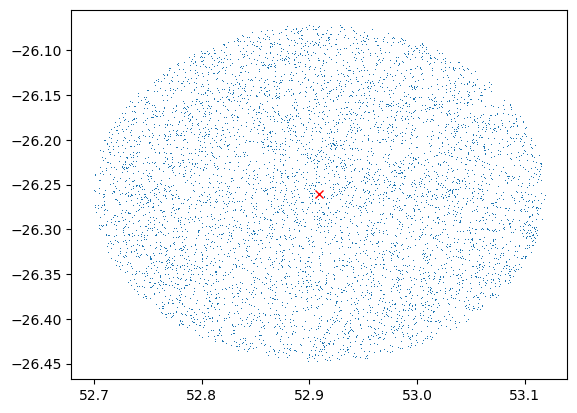

In [27]:
# check that the positions make sense for cluster and galaxies
plt.plot(cat['ra'], cat['dec'] ,',')
plt.plot(info['ra'], info['dec'], 'rx')

Hopefully this is the information you need to do the next steps, but let me know if not!